In [1]:
import numpy as np
import scipy as sp
from IPython.display import display, Math, Latex


# Features for images

### Normalized Mutual Information

$$MI(X,Y)=H(Y)-H(Y|X)$$
$$H(Y)=-\sum_y{p(y)ln(p(y))}$$
$$H(Y|X)=-\sum_x{p(x)}\sum_y{p(y|x)ln(p(y|x))}$$
$$NMI(X,Y)=\frac{MI(X,Y)}{H(Y)}$$

In [2]:
from collections import defaultdict

def nmi(x, y):
    def probs(X, Y=None):
        if Y is None:
            alphabet = np.unique(X)
            prs = defaultdict(float)
        else:
            alphabet = np.unique(Y)
            prs = defaultdict(dict)

        if Y is None:
            for x in X:
                prs[x] += 1 / float(X.size)
        else:
            for y in alphabet:
                X_filtered = X[(Y == y)]
                prs[y] = probs(X_filtered)

        return dict(prs)


    def entropy(X, Y=None):
        s = 0

        if Y is None:
            X_probs = probs(X)

            for p in X_probs.values():
                s += p * np.log(p)
        else:
            Y_probs = probs(Y)
            cond_probs = probs(X, Y)

            for y, values in cond_probs.iteritems():
                for val in values.values():
                    s += Y_probs[y] * val * np.log(val)
        return -s
    
    
    H_y = entropy(y)
    H_yx = entropy(y, x)
    
    return (H_y - H_yx) / H_y

In [3]:
def PCA_fit(X, num_components):
    n_samples, n_features = X.shape
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
   
    X -= X_mean
   
    U, S, V = np.linalg.svd(X, full_matrices=False)
   
    exp_var = (S ** 2) / n_samples
    exp_var = exp_var[:num_components]
    G = V[:num_components]
   
    return G.T, exp_var, X_mean, X_std

## Dataset load and setup

In [4]:
# Random state
random_state = 0
DIMENSIONS = 64

In [5]:
from sklearn.datasets import load_digits

digits = load_digits()
targets = digits.target
data_imgs = digits.images

images = np.zeros((data_imgs.shape[0], data_imgs.shape[1] ** 2))

for i in xrange(len(images)):
    images[i] = data_imgs[i].ravel()

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, targets, 
                                                    train_size=0.6, random_state=random_state)

## Logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train, y_train)

baseline_score = LR.score(X_test, y_test)

print 'Score on usual Logistic regression is {0}'.format(baseline_score)

Score on usual Logistic regression is 0.948539638387


## Logistic regression using NMI

In [8]:
# Calculation of nmi for all features (in this dataset, pixels)
nmis = np.array([nmi(X_train[:,i], y_train) for i in xrange(X_train.shape[1])])

<matplotlib.colorbar.Colorbar instance at 0x108089a70>

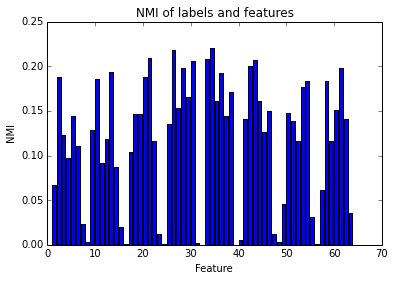

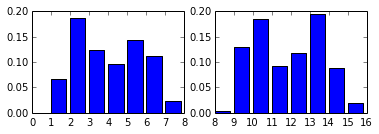

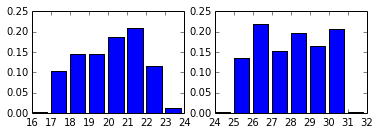

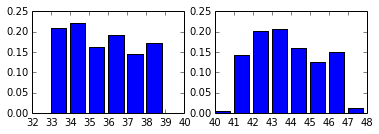

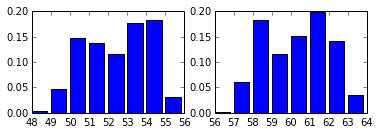

/Library/Python/2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


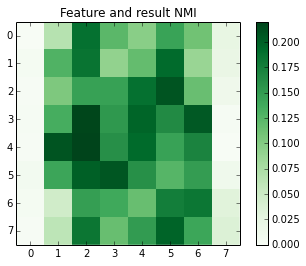

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('NMI of labels and features')
plt.xlabel('Feature')
plt.ylabel('NMI')

x = range(64)

ax = plt.subplot(111)
ax.bar(x, nmis)


for i in range(4):
    fig = plt.figure()
    ax = fig.add_subplot(2, 2, 1)
    
    begin = i * 2 * 8
    
    ax.bar(x[begin : begin + 8], nmis[begin : begin + 8])
    
    ax = fig.add_subplot(2, 2, 2)
    ax.bar(x[begin + 8 : begin + 16], nmis[begin + 8 : begin + 16])
    


fig = plt.figure()

nmi_image = nmis.reshape((8, 8))

a = fig.add_subplot(111)
a.set_title('Feature and result NMI')
plt.imshow(nmi_image, interpolation='none', cmap=plt.cm.Greens)
plt.colorbar()

In [10]:
# nmi values for each feature
nmis = np.zeros(X_train.shape[1])

for i in range(X_train.shape[1]):
    nmis[i] = nmi(X_train[:,i], y_train)

max_nmis = max(nmis)
nmis_range = np.arange(0, max_nmis, 0.02)

i = 0
best_sc = 0
best_th = 0


scores = np.zeros((nmis_range.shape[0], 2))

i = 0

for th in nmis_range:
    r = np.array(range(64))
    r = r[(nmis > th)]
    
    X_new_train = X_train[:,r]
    X_new_test = X_test[:,r]
    
    lr = LogisticRegression()
    
    lr.fit(X_new_train, y_train)
    
    sc = lr.score(X_new_test, y_test)
    
    scores[i][0] = sc
    scores[i][1] = X_new_train.shape[1]
    i += 1
    
    
    if sc >= best_sc:
        best_th = th
        best_sc = sc
        best_fn = X_new_train.shape[1]
    
    print 'With threshold {0} score is {1}, num of features: {2}'.format(
        th, sc, X_new_train.shape[1])
print '\n'
print 'Best score: {0}, num of features: {1}'.format(best_sc, best_fn)

With threshold 0.0 score is 0.948539638387, num of features: 64
With threshold 0.02 score is 0.948539638387, num of features: 51
With threshold 0.04 score is 0.947148817803, num of features: 48
With threshold 0.06 score is 0.948539638387, num of features: 47
With threshold 0.08 score is 0.945757997218, num of features: 45
With threshold 0.1 score is 0.948539638387, num of features: 42
With threshold 0.12 score is 0.940194714882, num of features: 36
With threshold 0.14 score is 0.936022253129, num of features: 31
With threshold 0.16 score is 0.916550764951, num of features: 21
With threshold 0.18 score is 0.887343532684, num of features: 16
With threshold 0.2 score is 0.749652294854, num of features: 7
With threshold 0.22 score is 0.207232267038, num of features: 1


Best score: 0.948539638387, num of features: 42


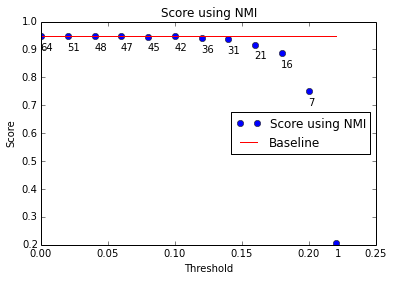

In [11]:
x = nmis_range
y = scores[:,0]


fix, ax = plt.subplots()

plt.title("Score using NMI")
plt.xlabel('Threshold')
plt.ylabel('Score')


x_1 = nmis_range
y_1 = [baseline_score] * x_1.size


ax.plot(x, y, 'bo', label='Score using NMI')
ax.plot(x_1, y_1, 'r', label='Baseline')



ax.legend(loc='center right')

for i in xrange(scores.shape[0]):
    plt.text(x[i], y[i] - 0.05, "{0}".format(int(scores[i][1])))

plt.show()

## Logistic regression using L1 regularization

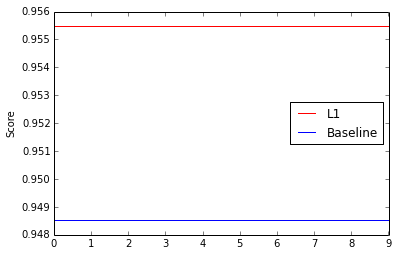

In [12]:
lr_l1 = LogisticRegression(penalty='l1', C=0.2)

lr_l1.fit(X_train, y_train)



lr_l1_score = lr_l1.score(X_test, y_test)

fix, ax = plt.subplots()

plt.xlabel('')
plt.ylabel('Score')


x_1 = range(10)
y_1 = [lr_l1_score] * len(x_1)
y_2 = [baseline_score] * len(x_1)

# ax.plot(x, y, 'bo', label='Score using NMI')
ax.plot(x_1, y_1, 'r', label='L1')
ax.plot(x_1, y_2, 'b', label='Baseline')

ax.legend(loc='center right')

<built-in method format of str object at 0x108482c30>


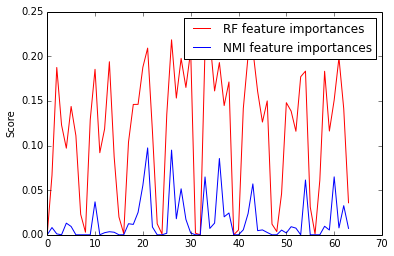

In [13]:
from sklearn.tree.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)
sc = dtr.score(X_test, y_test)

print 'Random forrest score: {0}'.format


fix, ax = plt.subplots()

plt.xlabel('')
plt.ylabel('Score')


x_1 = range(64)
y_1 = nmis
y_2 = dtr.feature_importances_


ax.plot(x_1, y_1, 'r', label='RF feature importances')
ax.plot(x_1, y_2, 'b', label='NMI feature importances')

ax.legend(loc='best')

Yes, those importances are definetly correlated. Both RF and NMI correctly find most unimportant and important features, rises and dropdowns have same trends.

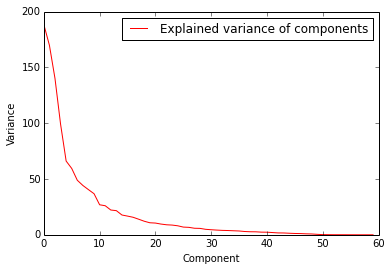

In [14]:
G, exp_var, X_mean, X_std = PCA_fit(X_train, 60)

x = range(60)
y = exp_var

fix, ax = plt.subplots()

plt.xlabel('Component')
plt.ylabel('Variance')


ax.plot(x, y, 'r', label='Explained variance of components')

ax.legend(loc='best')